## In this file, I will build some predictive Machine Learning models.
  
This will be done using scikit-learn and will be based on the data we got after working in the '*Data_Engineering*' file.

--------------------------------

To start, we have *208786 lines* of ETH's recent history with a bunch of Technical Indicators added.  

First, I want to split the dataset into training and learning parts.
  
And we have a few options here:
- As our data is time series, I am wondering if it would be better to use CrossValidation, more specifically - **TimeSeriesSplit**.
          
The advantages of this approach might be:
1) Model will **generalize well** to unseen data.
2) If we use a low number of *n_split* param., our **dataset is big enough** to ensure that every testing in the CrossValidation process was made on a sufficient amount of data.
3) We can still have a **hold-out set** of data to ensure that the best performance was reached.
      
- OR, We can also do the splitting, with a more **classical approach**, where we simply set, let's say, ~85% of data to training and the remaining ~15% goes to testing.

The advantages of this 'Classical Approach' might be:
1) It is **very fast and easy** to implement.
2) Less computation, as we are training and validating the model just once.


### Thought on that: 

- While the **classical split** is simple and fast, it gives us **only one chance** to evaluate our model — which may result in misleading performance if the testing set happens to be too easy or too difficult (especially relevant in volatile markets like we have).

- **TimeSeriesSplit**, on the other hand, evaluates the model on **multiple, progressively later windows**, simulating how your model would perform if retrained and deployed in the future. This makes it more **robust and realistic** for time-dependent data.

---

##### The Final Choice:

I will use **TimeSeriesSplit** (with `n_splits = 3`) for **model selection and tuning**, followed by a final **hold-out test set** (e.g. last 10% of the data) to **simulate live performance**.

This balances generalization, robustness, and real-world reliability.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [4]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
df = pd.read_csv('..\main_data\Final_Data_ETH.csv',
                index_col=0, parse_dates=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208786 entries, 2024-09-12 16:16:00 to 2025-02-04 16:01:00
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Close            208786 non-null  float64
 1   EMA_8            208786 non-null  float64
 2   EMA_21           208786 non-null  float64
 3   Prise_Direction  208786 non-null  int64  
 4   SMA_50           208786 non-null  float64
 5   SMA_200          208786 non-null  float64
 6   RSI_10           208786 non-null  float64
 7   RSI_14           208786 non-null  float64
 8   RSI_30           208786 non-null  float64
 9   ROC_10           208786 non-null  float64
 10  ROC_14           208786 non-null  float64
 11  Momentum_14      208786 non-null  float64
 12  Stoch_%K_14      208786 non-null  float64
 13  Stoch_%D_14      208786 non-null  float64
 14  Stoch_%K_200     208786 non-null  float64
 15  Stoch_%D_200     208786 non-null  float64
 16  Targ

In [123]:
X = df.drop(columns=['Target_Signal'])
y = df['Target_Signal']

# Convert to numpy for indexing
X_np = X.values
y_np = y.values

# Reserve the last 10% as a final hold-out set
holdout_size = int(len(X_np) * 0.10)
X_holdout, y_holdout = X_np[-holdout_size:], y_np[-holdout_size:]
X_train_val, y_train_val = X_np[:-holdout_size], y_np[:-holdout_size]

# TimeSeriesSplit on the remaining 90%
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Show the split info
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_val)):
    print(f"Fold: {fold+1}")
    print("TRAIN indices:", train_index[:5], "...", train_index[-5:])
    print("TEST indices:", test_index[:5], "...", test_index[-5:])
    print()


Fold: 1
TRAIN indices: [0 1 2 3 4] ... [46972 46973 46974 46975 46976]
TEST indices: [46977 46978 46979 46980 46981] ... [93949 93950 93951 93952 93953]

Fold: 2
TRAIN indices: [0 1 2 3 4] ... [93949 93950 93951 93952 93953]
TEST indices: [93954 93955 93956 93957 93958] ... [140926 140927 140928 140929 140930]

Fold: 3
TRAIN indices: [0 1 2 3 4] ... [140926 140927 140928 140929 140930]
TEST indices: [140931 140932 140933 140934 140935] ... [187903 187904 187905 187906 187907]



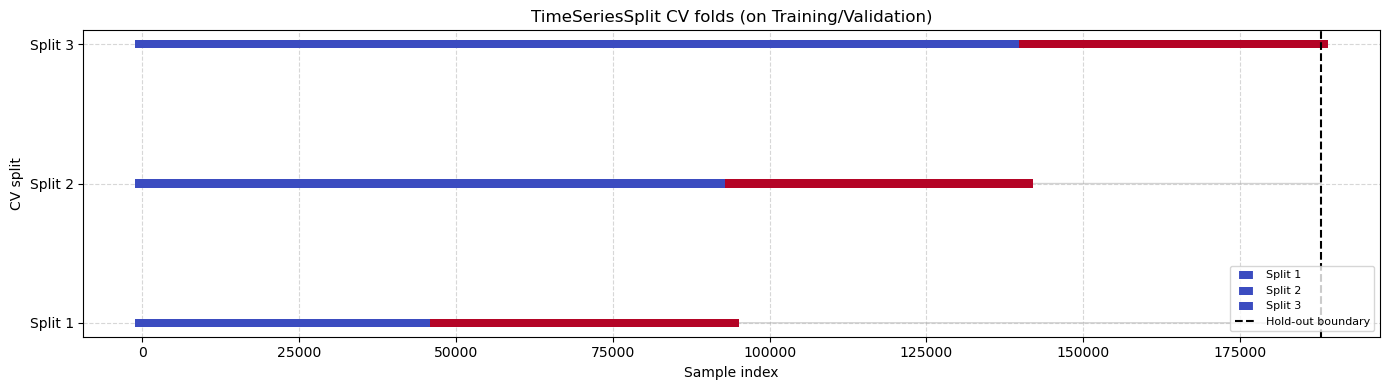

In [8]:
# For us to see how it works, let's plot the indices of the splits:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    X = np.asarray(X)
    n_samples = X.shape[0]

    for ii, (train, test) in enumerate(cv.split(X)):
        indices = np.full(n_samples, np.nan)
        indices[train] = 0
        indices[test] = 1

        ax.plot(range(n_samples), [ii + 0.5] * n_samples,
                c='lightgray', lw=1, zorder=1)

        ax.scatter(range(n_samples), [ii + 0.5] * n_samples,
                   c=indices, marker='|', cmap=plt.cm.coolwarm,
                   lw=lw, label=f"Split {ii+1}", zorder=2)

    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=[f"Split {i+1}" for i in range(n_splits)],
        xlabel="Sample index",
        ylabel="CV split",
        title="TimeSeriesSplit CV folds (on Training/Validation)"
    )
    ax.axvline(x=n_samples, color='black', linestyle='--', label="Hold-out boundary")
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

# Plot the CV indices
fig, ax = plt.subplots(figsize=(14, 4))
plot_cv_indices(tscv, X_train_val, y_train_val, ax=ax, n_splits=n_splits)
plt.tight_layout()
plt.show()

--------------------

### So, now we can move to **creation of first models**. 
For now, I want to see how different algorithms with almost **default hyperparameters** perform on our main part of the data.
I will change some of the hyperparameters just to optimize models to the noisy, non-linear, highly-dimensional data that we have.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier # Prefer to use it obver GradientBoostingClassifier for large datasets
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [10]:
# First, we need to decide on the models that we want to use.

models = []

# "Lightweight" Models would be:  
models.append(('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance')))  
             
models.append(('LR', LogisticRegression(C=1, solver='lbfgs', max_iter=3000, penalty='l2',
                                        random_state=101))) 

models.append(('LDA', LinearDiscriminantAnalysis(solver='svd'))) # LDA usually works well with default parameters, but we might fine-tune them later.

# More "Advanced" Models:

models.append(('HGB', HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=7, 
                                                     l2_regularization=1.0,
                                                     random_state=101)))


models.append(('CAT', CatBoostClassifier(silent=True, n_estimators=50,  
                                         depth=8, learning_rate=0.1, 
                                         random_seed=101)))

models.append(('RF', RandomForestClassifier(n_estimators=100,
                                           max_depth=10, min_samples_split=3,
                                           min_samples_leaf=2, max_features='sqrt', 
                                           random_state=101))) 

models.append(('LGBM', LGBMClassifier(n_estimators=100, max_depth=10,
                                         learning_rate=0.1,
                                         random_state=101))) # I prefer LGBM over XGBoost here, 

# but you can also use XGBoost if you want to:

#models.append(('XGB', XGBClassifier(n_estimators=25))) 

# XGB is not that optimized, might take a while to run.


In [57]:
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler

In [12]:
def train_and_evaluate_models(models, X_train_val, y_train_val, tscv,
                              X_holdout, y_holdout,
                              metrics_cv, n_splits=3,
                              plot_id=[True, True],
                              cv_yrange=None):

    """
    Parameters:
    - models: list of tuples (name, model)
    - X_train_val, y_train_val: arrays for CV training
    - X_holdout, y_holdout: arrays for final evaluation
    - metrics_cv: list of CV metric functions (e.g., [accuracy_score])
    - plot_id: [plot_CV, plot_CM]
    - cv_yrange: (min, max) for CV plot y-axis

    Returns:
    - results_df: DataFrame of mean CV and Holdout accuracies and training time
    """


    print(f'\n Cross-validation with {n_splits} splits, metrics: {[m.__name__ for m in metrics_cv]}\n')

    all_cv_scores = []
    holdout_accuracies = []
    training_times = []
    model_names = []
    cv_fold_accuracies_per_model = []
    models_requiring_scaling = ['LR', 'KNN', 'LDA']

    for name, model in models:
        print(f"Evaluating model: {name}")
        model_names.append(name)

        cv_fold_scores = []
        cv_fold_accuracies = []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val)):
            X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

            if name in models_requiring_scaling:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            fold_score = {metric.__name__: metric(y_val, y_pred) for metric in metrics_cv}
            cv_fold_scores.append(fold_score)
            cv_fold_accuracies.append(fold_score[metrics_cv[0].__name__])

            print(f"  Fold {fold+1} scores: {fold_score}")

        mean_scores = {k: np.mean([f[k] for f in cv_fold_scores]) for k in cv_fold_scores[0]}
        all_cv_scores.append(mean_scores)
        cv_fold_accuracies_per_model.append(cv_fold_accuracies)

        # Holdout evaluation with timing
        start_time = time.time()
        if name in models_requiring_scaling:
            scaler = StandardScaler()
            X_train_val_scaled = scaler.fit_transform(X_train_val)
            X_holdout_scaled = scaler.transform(X_holdout)
            model.fit(X_train_val_scaled, y_train_val)
            y_pred_holdout = model.predict(X_holdout_scaled)
        else:
            model.fit(X_train_val, y_train_val)
            y_pred_holdout = model.predict(X_holdout)
        end_time = time.time()

        acc = metrics_cv[0](y_holdout, y_pred_holdout)
        holdout_accuracies.append(acc)
        training_times.append(end_time - start_time)

        # Print classification report
        print("\n Classification Report:")
        print(classification_report(y_holdout, y_pred_holdout))

        # Plot confusion matrix
        if plot_id[1]:
            cm = confusion_matrix(y_holdout, y_pred_holdout)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f"{name} - Holdout Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.tight_layout()
            plt.show()

    # Create result DataFrame
    results_df = pd.DataFrame({
        'Model': model_names,
        'CV Mean Accuracy': [scores[metrics_cv[0].__name__] for scores in all_cv_scores],
        'Holdout Accuracy': holdout_accuracies,
        'Train Time (s)': training_times
    })

    # Boxplot of CV scores
    if plot_id[0]:
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.boxplot(data=cv_fold_accuracies_per_model)
        sns.stripplot(data=cv_fold_accuracies_per_model, color=".25", jitter=True)
        ax.set_xticklabels(model_names)
        ax.set_title(f"{n_splits}-Fold CV Accuracy Scores")
        ax.set_ylabel("Accuracy")
        if cv_yrange:
            ax.set_ylim(cv_yrange)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return results_df


 Cross-validation with 3 splits, metrics: ['accuracy_score']

Evaluating model: KNN
  Fold 1 scores: {'accuracy_score': 0.852097835110799}
  Fold 2 scores: {'accuracy_score': 0.8112267705472891}
  Fold 3 scores: {'accuracy_score': 0.8808991634203972}

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     10412
         1.0       0.90      0.88      0.89     10466

    accuracy                           0.89     20878
   macro avg       0.89      0.89      0.89     20878
weighted avg       0.89      0.89      0.89     20878



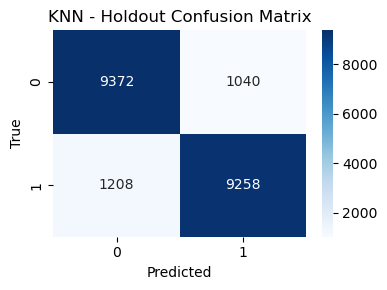

Evaluating model: LR
  Fold 1 scores: {'accuracy_score': 0.9294548396023586}
  Fold 2 scores: {'accuracy_score': 0.9336696681354706}
  Fold 3 scores: {'accuracy_score': 0.9317112629584691}

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93     10412
         1.0       0.94      0.93      0.93     10466

    accuracy                           0.93     20878
   macro avg       0.93      0.93      0.93     20878
weighted avg       0.93      0.93      0.93     20878



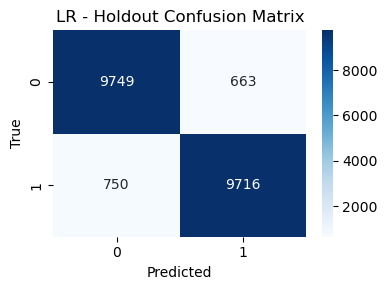

Evaluating model: LDA
  Fold 1 scores: {'accuracy_score': 0.9216637929199395}
  Fold 2 scores: {'accuracy_score': 0.9276880175404986}
  Fold 3 scores: {'accuracy_score': 0.9212593396768631}

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93     10412
         1.0       0.93      0.92      0.93     10466

    accuracy                           0.93     20878
   macro avg       0.93      0.93      0.93     20878
weighted avg       0.93      0.93      0.93     20878



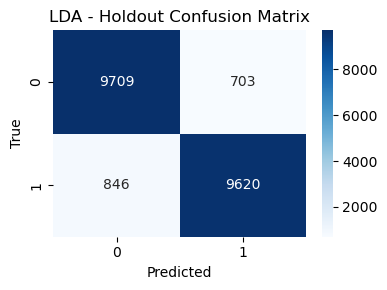

Evaluating model: HGB
  Fold 1 scores: {'accuracy_score': 0.9298380058326415}
  Fold 2 scores: {'accuracy_score': 0.9357770824020265}
  Fold 3 scores: {'accuracy_score': 0.9322434382783064}

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93     10412
         1.0       0.94      0.93      0.93     10466

    accuracy                           0.93     20878
   macro avg       0.93      0.93      0.93     20878
weighted avg       0.93      0.93      0.93     20878



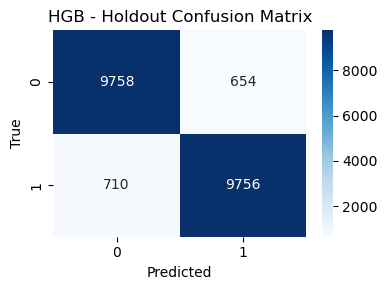

Evaluating model: CAT
  Fold 1 scores: {'accuracy_score': 0.9152351150563042}
  Fold 2 scores: {'accuracy_score': 0.9220895331758094}
  Fold 3 scores: {'accuracy_score': 0.9185346020392958}

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92     10412
         1.0       0.93      0.92      0.92     10466

    accuracy                           0.92     20878
   macro avg       0.92      0.92      0.92     20878
weighted avg       0.92      0.92      0.92     20878



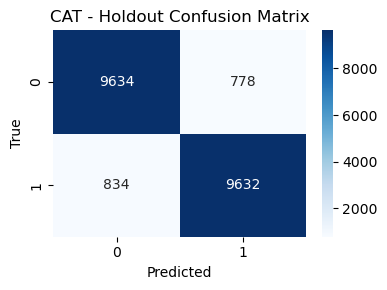

Evaluating model: RF
  Fold 1 scores: {'accuracy_score': 0.9097430657555825}
  Fold 2 scores: {'accuracy_score': 0.9175128254252081}
  Fold 3 scores: {'accuracy_score': 0.9112331566511271}

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     10412
         1.0       0.92      0.92      0.92     10466

    accuracy                           0.92     20878
   macro avg       0.92      0.92      0.92     20878
weighted avg       0.92      0.92      0.92     20878



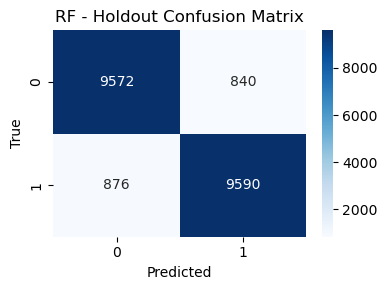

Evaluating model: LGBM
[LightGBM] [Info] Number of positive: 23441, number of negative: 23536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 46977, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498989 -> initscore=-0.004045
[LightGBM] [Info] Start training from score -0.004045


c:\Users\Lenovo\conda\envs\main\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1 scores: {'accuracy_score': 0.9299657279094025}
[LightGBM] [Info] Number of positive: 46684, number of negative: 47270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 93954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496881 -> initscore=-0.012474
[LightGBM] [Info] Start training from score -0.012474


c:\Users\Lenovo\conda\envs\main\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2 scores: {'accuracy_score': 0.9344998616344169}
[LightGBM] [Info] Number of positive: 69902, number of negative: 71029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 140931, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496002 -> initscore=-0.015994
[LightGBM] [Info] Start training from score -0.015994


c:\Users\Lenovo\conda\envs\main\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 3 scores: {'accuracy_score': 0.9329671967132852}
[LightGBM] [Info] Number of positive: 93120, number of negative: 94788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 187908, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495562 -> initscore=-0.017754
[LightGBM] [Info] Start training from score -0.017754

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93     10412
         1.0       0.94      0.93      0.93     10466

    accuracy                           0.93     20878
   macro avg       0.93      0.93      0.93     20878
weighted avg       0.93      0.93      0.93     20878



c:\Users\Lenovo\conda\envs\main\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


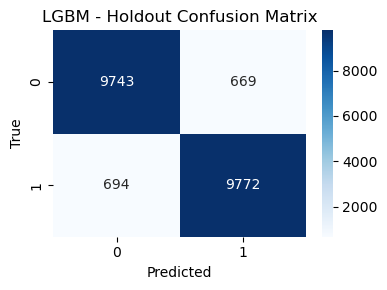

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13060\4054972701.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names)


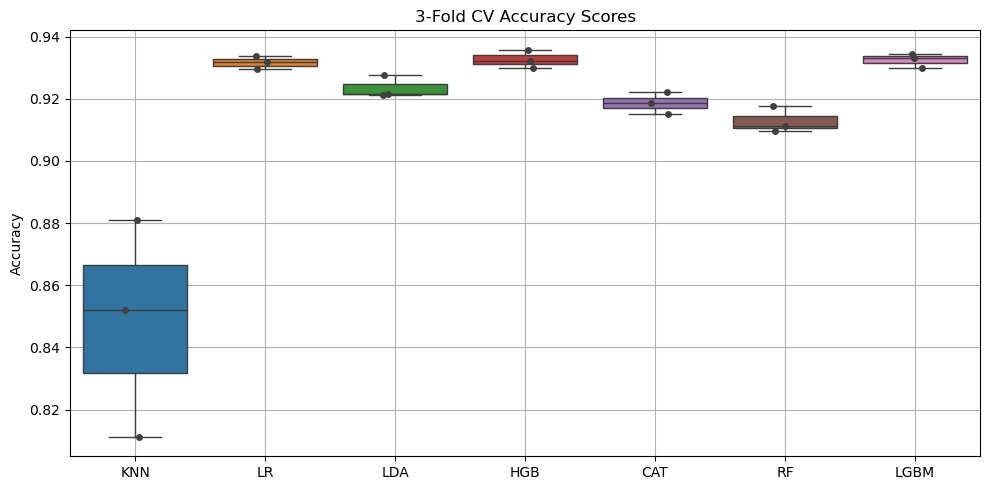


Results DataFrame:
  Model  CV Mean Accuracy  Holdout Accuracy  Train Time (s)
0   KNN          0.848075          0.892327        1.820626
1    LR          0.931612          0.932321        1.050877
2   LDA          0.923537          0.925807        0.207826
3   HGB          0.932620          0.934668        0.842871
4   CAT          0.918620          0.922790        1.182633
5    RF          0.912830          0.917808       51.887541
6  LGBM          0.932478          0.934716        0.495798


In [13]:
results_df = train_and_evaluate_models(
    models=models,
    X_train_val=X_train_val,
    y_train_val=y_train_val,
    X_holdout=X_holdout,
    y_holdout=y_holdout,
    tscv=tscv,
    metrics_cv=[accuracy_score],
    plot_id=[True, True]
)
print("\nResults DataFrame:")
print(results_df)

Why LogisticRegressor got that good results?

In [14]:
# Let's see the feature importances of the models that support it:
def plot_feature_importances(model, X, model_name, n_features=10):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        raise ValueError(f"Model {model_name} does not support feature importances.")

    indices = np.argsort(importances)[::-1][:n_features]
    plt.figure(figsize=(10, 6))
    plt.title(f"Top {n_features} Feature Importances for {model_name}")
    sns.barplot(x=importances[indices], y=X.columns[indices])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [16]:
models

[('KNN', KNeighborsClassifier(weights='distance')),
 ('LR', LogisticRegression(C=1, max_iter=3000, random_state=101)),
 ('LDA', LinearDiscriminantAnalysis()),
 ('HGB',
  HistGradientBoostingClassifier(l2_regularization=1.0, max_depth=7,
                                 random_state=101)),
 ('CAT', <catboost.core.CatBoostClassifier at 0x1ec9a8bf750>),
 ('RF',
  RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=3,
                         random_state=101)),
 ('LGBM', LGBMClassifier(max_depth=10, random_state=101))]

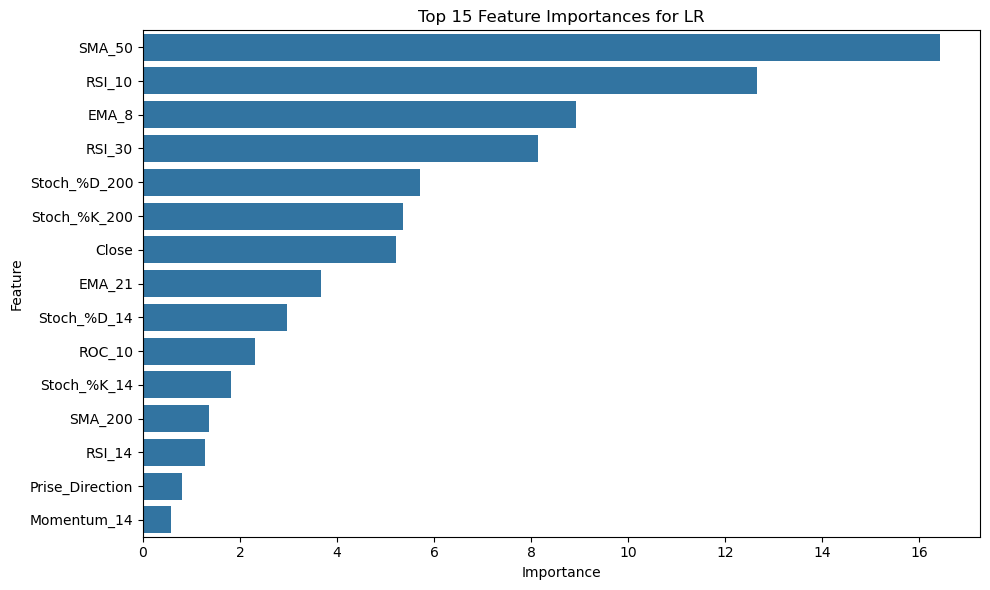

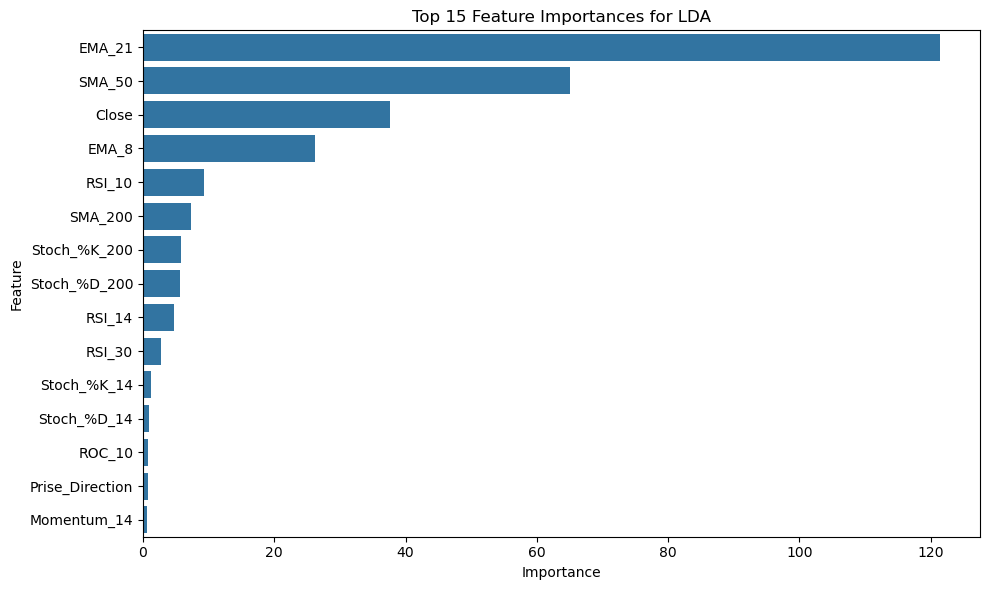

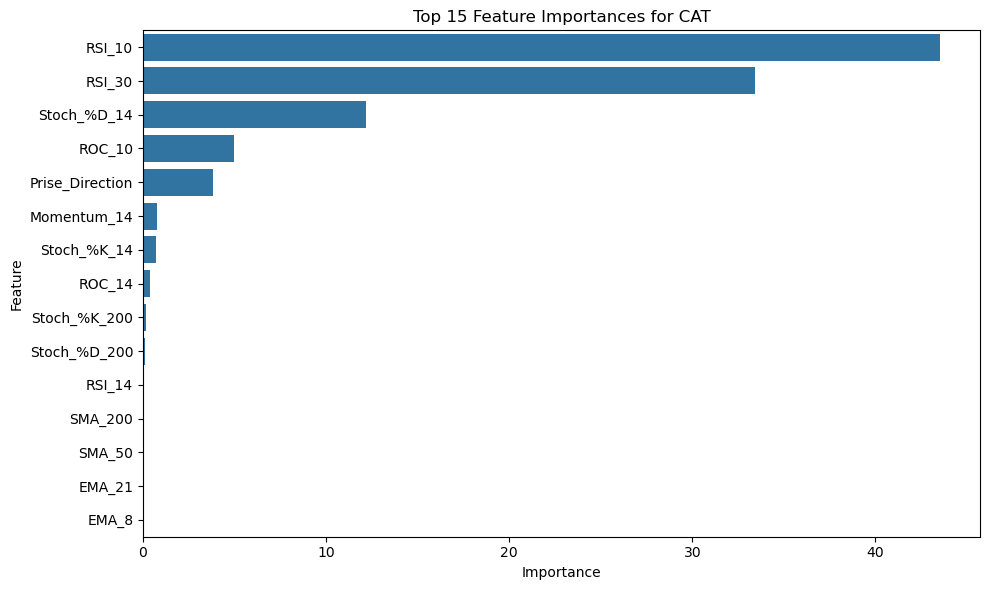

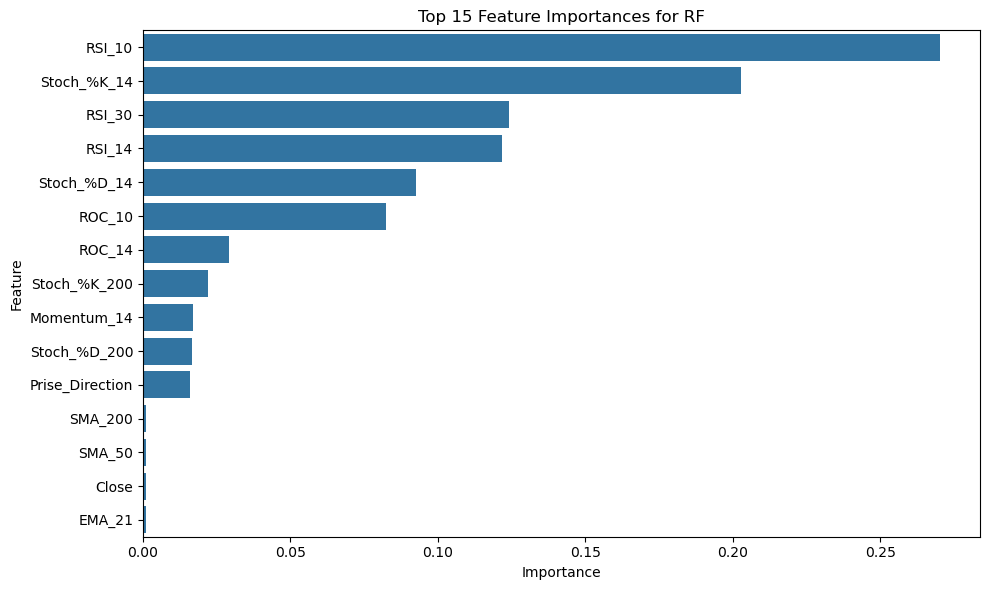

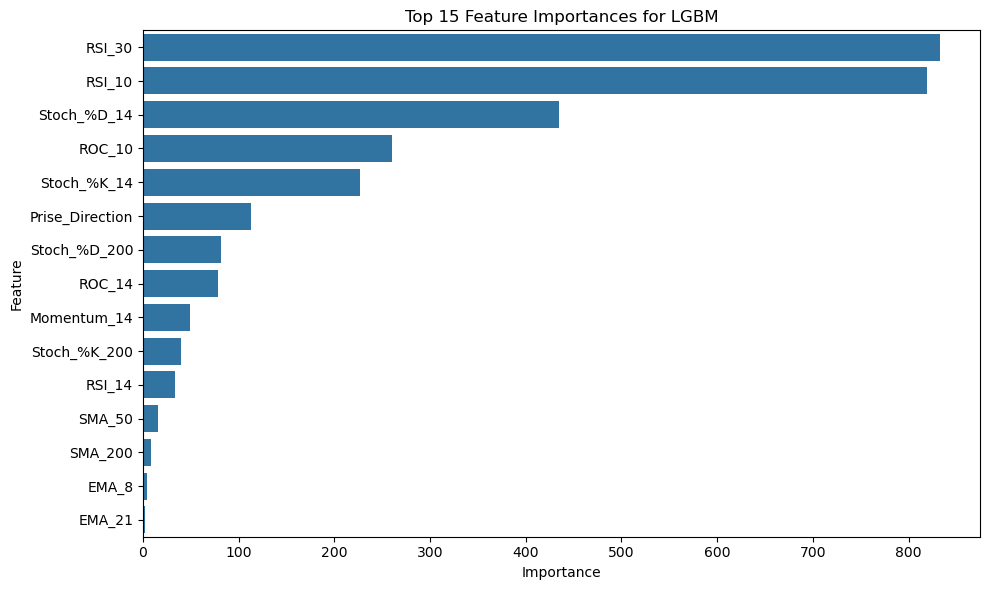

In [ ]:
# Plot feature importances for each model

# KNN does not have feature importances, so we skip it
for model in models:  
    if model[0] in ['LR', 'LDA', 'RF', 'CAT', 'LGBM']:
        plot_feature_importances(model[1], X, model[0], n_features=15)

After annalyzing the result we got, I want us to focus on 2 particular models that performed best and fastest. 
That was: 
1) HGB (HistGradientBoostingClassifier) – highest holdout accuracy (0.934668) with fast training.

2) LGBM (LightGBMClassifier) – nearly identical performance (0.934716), also fast and preferred by me.

Now, we will fine-tune hyperparamethers for these 2 models with a GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV

In [33]:
tscv = TimeSeriesSplit(n_splits=3)

# 1. HGB Hyperparameter Grid
# I use this hyperparameter grid as an example. You can modify it based on your needs, 
# but I believe this is the best hyperparams you can use for GridSearchCV when using it with HMB.

hgb = HistGradientBoostingClassifier(random_state=42)
hgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [50, 100, 150],
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [10, 20],
    'l2_regularization': [0.0, 0.1, 1.0]
}

hgb_grid = GridSearchCV(
    hgb,
    hgb_param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# 2. LGBM Grid Search
# Again, I use this hyperparameter grid as an example. You can modify it based on your needs.

lgbm = LGBMClassifier(random_state=42)
lgbm_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, -1],
    'num_leaves': [15, 31, 63],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
}

lgbm_grid = GridSearchCV(
    lgbm, 
    lgbm_param_grid, 
    cv=tscv, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2
)

In [24]:
# Let's start from the HistGradientBoostingClassifier.

hgb_grid.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 10, None],
                         'max_iter': [50, 100, 150],
                         'min_samples_leaf': [10, 20]},
             scoring='accuracy', verbose=2)

In [53]:
best_model_hgb = HistGradientBoostingClassifier(l2_regularization=1.0, max_depth=10,
                               max_iter=150, random_state=42)

In [54]:
best_model_hgb.fit(X_train_val, y_train_val)

HistGradientBoostingClassifier(l2_regularization=1.0, max_depth=10,
                               max_iter=150, random_state=42)

In [34]:
# Now let's move to the LGBMClassifier.

lgbm_grid.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 4860 candidates, totalling 14580 fits
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 93120, number of negative: 94788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, -1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'n_estimators': [50, 100, 150],
                         'num_leaves': [15, 31, 63], 'reg_alpha': [0.1, 0.5]},
             scoring='accuracy', verbose=2)

In [ ]:
best_model_lgbm = lgbm_grid.best_estimator_

In [52]:
import joblib

joblib.dump(best_model_lgbm, 'best_model_lgbm.pkl')

['best_model_lgbm.pkl']

In [55]:
joblib.dump(best_model_hgb, 'best_model_hgb.pkl')

['best_model_hgb.pkl']

In [124]:
final_hgb_pred = pd.Series(best_model_hgb.predict(X_holdout), index=df.index[-holdout_size:])
final_lgbm_pred = pd.Series(best_model_lgbm.predict(X_holdout), index=df.index[-holdout_size:])

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


c:\Users\Lenovo\conda\envs\main\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Let's evaluate our final models:

In [58]:
def eval_final_models(y_true, pred1, pred2, model_names=["HGB", "LGBM"]):
    """
    Evaluate two final models on hold-out data using key classification metrics.

    Parameters:
    - y_true: True labels
    - pred1: Predictions from model 1
    - pred2: Predictions from model 2
    - model_names: List of model names [model1_name, model2_name]
    """

    def eval_one_model(y_true, y_pred, name):
        print(f"\n Evaluation for {name}:")
        print("-" * 30)
        print(classification_report(y_true, y_pred, digits=4))

        metrics = {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, average='binary'),
            "Recall": recall_score(y_true, y_pred, average='binary'),
            "F1 Score": f1_score(y_true, y_pred, average='binary')
        }

        # If binary classification (0 and 1), compute AUC
        if set(y_true) == {0, 1}:
            try:
                metrics["ROC AUC"] = roc_auc_score(y_true, y_pred)
            except:
                metrics["ROC AUC"] = None

        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

        return confusion_matrix(y_true, y_pred)

    # Evaluate each model
    cm1 = eval_one_model(y_true, pred1, model_names[0])
    cm2 = eval_one_model(y_true, pred2, model_names[1])

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f"{model_names[0]} Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title(f"{model_names[1]} Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()


 Evaluation for HGB:
------------------------------
              precision    recall  f1-score   support

         0.0     0.9340    0.9395    0.9367     10412
         1.0     0.9395    0.9340    0.9367     10466

    accuracy                         0.9367     20878
   macro avg     0.9367    0.9367    0.9367     20878
weighted avg     0.9367    0.9367    0.9367     20878

Accuracy: 0.9367
Precision: 0.9395
Recall: 0.9340
F1 Score: 0.9367
ROC AUC: 0.9367

 Evaluation for LGBM:
------------------------------
              precision    recall  f1-score   support

         0.0     0.9339    0.9405    0.9372     10412
         1.0     0.9404    0.9338    0.9371     10466

    accuracy                         0.9372     20878
   macro avg     0.9372    0.9372    0.9372     20878
weighted avg     0.9372    0.9372    0.9372     20878

Accuracy: 0.9372
Precision: 0.9404
Recall: 0.9338
F1 Score: 0.9371
ROC AUC: 0.9372


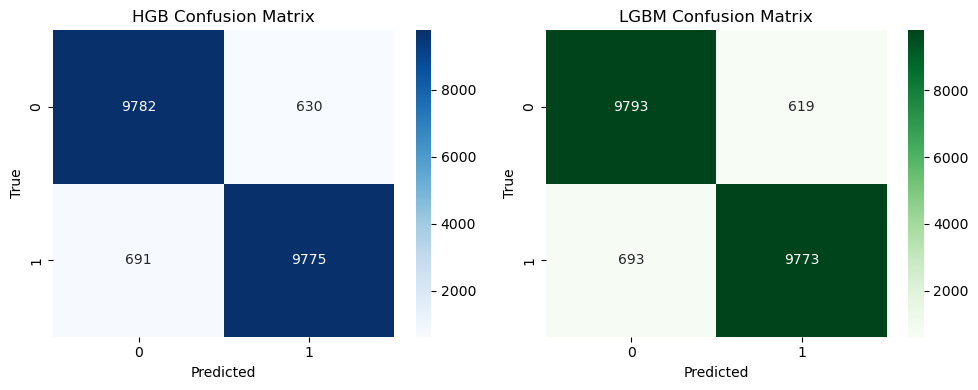

In [59]:
eval_final_models(y_holdout, final_hgb_pred, final_lgbm_pred)